In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ctapipe.io import read_table
from ctapipe.visualization import CameraDisplay
from ctapipe_io_lst import load_camera_geometry
from ctapipe.coordinates import EngineeringCameraFrame
from lstchain.io import get_dataset_keys
from ctapipe.io.hdf5tableio import HDF5TableReader

# camera monitoring containers
from ctapipe.containers import (
    FlatFieldContainer,
    WaveformCalibrationContainer,
    PedestalContainer,
    PixelStatusContainer,
)

# HG=0 LG=1
channel=["HG","LG"]

<font size="4">Read the calibration file of data 20210915 : <br>
<ul>    
<li> data in  [data_tree_base_dir]/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/calibration_filters_52.Run06317.0000.h5    
<li> you can check the control plots in [data_tree_base_dir]/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/log/calibration_filters_52.Run06317.0000.pdf
</ul>    
</font>


In [56]:
# change the data tree root dir with your local tree
#file_name="/fefs/aswg/data/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/calibration_filters_52.Run06317.0000.h5"
file_name="/Users/cassol/Documents/soft/2022_01_lstchain_school/data/real/monitoring/PixelCalibration/LevelA/calibration/20210915/pro/calibration_filters_52.Run06317.0000.h5"

tel_id=1 

# find the keys' name
dataset_keys=get_dataset_keys(file_name)
print(f"file keys: {dataset_keys}")


file keys: ['/tel_1/calibration', '/tel_1/flatfield', '/tel_1/pedestal', '/tel_1/pixel_status']


In [63]:

# read the calibration table
table = read_table(file_name, dataset_keys[1])

In [64]:
table

sample_time,sample_time_min,sample_time_max,n_events,"charge_mean [2,1855]","charge_median [2,1855]","charge_std [2,1855]","time_mean [2,1855]","time_median [2,1855]","time_std [2,1855]","relative_gain_mean [2,1855]","relative_gain_median [2,1855]","relative_gain_std [2,1855]","relative_time_median [2,1855]","charge_median_outliers [2,1855]","charge_std_outliers [2,1855]","time_median_outliers [2,1855]"
s,s,s,,,,,ns,ns,ns,,,,ns,,,
float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool
5.873421469906881e-05,1631760278.86569,1631760289.0149622,10000,6246.182885351563 .. 381.25078764038085,6233.855712890625 .. 379.4313201904297,760.9203758344082 .. 52.85043741054942,17.792933484077455 .. 16.94433800830841,17.75107765197754 .. 16.905936241149902,1.0474650491235677 .. 1.0493258839995099,1.0004762918604435 .. 1.062131719625482,0.99834043818003 .. 1.0570819598082042,0.12203869365259722 .. 0.146684417529351,1.033951759338379 .. -0.18059825897216797,False .. False,False .. False,False .. False


In [49]:
# an other way to read the data is to upload them in the ctapipe monitoring containers

# declare the monitoring containers
ff_data = FlatFieldContainer()
ped_data = PedestalContainer()
calib_data = WaveformCalibrationContainer()
status_data = PixelStatusContainer()

# read the file
with HDF5TableReader(file_name) as h5_table:
    assert h5_table._h5file.isopen == True

    table = f"/tel_{tel_id}/flatfield"
    next(h5_table.read(table, ff_data))
    table = f"/tel_{tel_id}/calibration"
    next(h5_table.read(table, calib_data))
    table = f"/tel_{tel_id}/pedestal"
    next(h5_table.read(table, ped_data))
    table = f"/tel_{tel_id}/pixel_status"
    next(h5_table.read(table, status_data))


In [65]:
# flat-field container
ff_data

ctapipe.containers.FlatFieldContainer:
                   sample_time: Time associated to the flat-field event set  [s]
               sample_time_min: Minimum time of the flat-field events [s]
               sample_time_max: Maximum time of the flat-field events [s]
                      n_events: Number of events used for statistics
                   charge_mean: np array of signal charge mean (n_chan, n_pix)
                 charge_median: np array of signal charge median (n_chan, n_pix)
                    charge_std: np array of signal charge standard deviation
                                (n_chan, n_pix)
                     time_mean: np array of signal time mean (n_chan, n_pix)
                                [ns]
                   time_median: np array of signal time median (n_chan, n_pix)
                                [ns]
                      time_std: np array of signal time standard deviation
                                (n_chan, n_pix) [ns]
            relative

<font size="5">Exercise: <br>
    
<font size="4"> Plot the plot FF median charge for the two channels <br>

In [66]:
# data shape: n_chan, n_pix
ff_data.charge_mean.shape

(2, 1855)

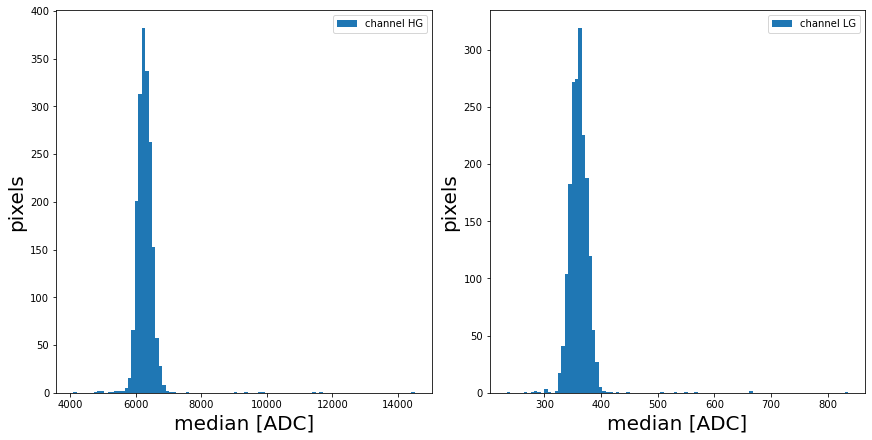

In [67]:
# plot ff events median charge for the two channels
fig, ax = plt.subplots(1, 2, figsize=(12,6),constrained_layout=True)
for chan in np.arange(2):
    label=f"channel {channel[chan]}"
    ax[chan].hist(ff_data.charge_mean[chan], bins=100,label=label)
    ax[chan].set_ylabel(f'pixels',fontsize=20) 
    ax[chan].set_xlabel(f'median [ADC]',fontsize=20) 
   
    ax[chan].legend()    


<font size="5">Exercise: <br>
    
<font size="4"> Plot the plot FF median charge over the camera for the two channels <br>

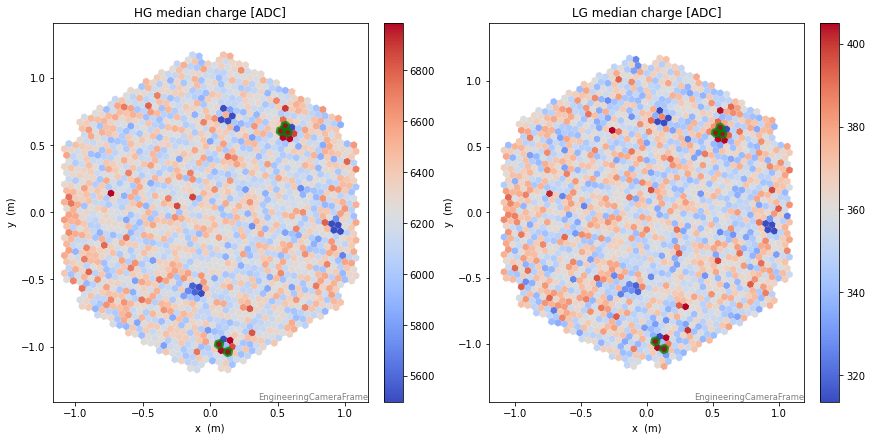

In [68]:
# plot ff events median charge over the camera for the two channels

# read camera geometry
camera = load_camera_geometry().transform_to(EngineeringCameraFrame())

fig, ax = plt.subplots(1, 2, figsize=(12,6),constrained_layout=True)
  
image = ff_data.charge_median

# ge the median charge outliers : pixels with values > x sigma from median camera value
mask = ff_data.charge_median_outliers

for chan in np.arange(2):
    disp = CameraDisplay(camera,ax=ax[chan])
    disp.image = image[chan]
    mymin = np.median(image[chan]) - 2 * np.std(image[chan])
    mymax = np.median(image[chan]) + 2 * np.std(image[chan])
    disp.set_limits_minmax(mymin, mymax)
    disp.highlight_pixels(mask[chan], linewidth=3)
    disp.cmap = plt.cm.coolwarm
    ax[chan].set_title(f"{channel[chan]} median charge [ADC]")
    disp.add_colorbar()
    


<font size="5">Other containers: <br>


In [69]:
# pedestal container
ped_data

ctapipe.containers.PedestalContainer:
                      n_events: Number of events used for statistics
                   sample_time: Time associated to the pedestal event set [s]
               sample_time_min: Time of first pedestal event [s]
               sample_time_max: Time of last pedestal event [s]
                   charge_mean: np array of pedestal average (n_chan, n_pix)
                 charge_median: np array of the pedestal  median (n_chan, n_pix)
                    charge_std: np array of the pedestal standard deviation
                                (n_chan, n_pix)
        charge_median_outliers: Boolean np array of the pedestal median outliers
                                (n_chan, n_pix)
           charge_std_outliers: Boolean np array of the pedestal std outliers
                                (n_chan, n_pix)

In [55]:
# pixel status container
status_data

ctapipe.containers.PixelStatusContainer:
       hardware_failing_pixels: Boolean np array (True = failing pixel) from the
                                hardware pixel status data (n_chan, n_pix)
       pedestal_failing_pixels: Boolean np array (True = failing pixel) from the
                                pedestal data analysis (n_chan, n_pix)
      flatfield_failing_pixels: Boolean np array (True = failing pixel) from the
                                flat-field data analysis (n_chan, n_pix)

In [12]:
# calibration data container
calib_data

ctapipe.containers.WaveformCalibrationContainer:
                          time: Time associated to the calibration event [s]
                      time_min: Earliest time of validity for the calibration
                                event [s]
                      time_max: Latest time of validity for the calibration
                                event [s]
                      dc_to_pe: np array of (digital count) to (photon electron)
                                coefficients (n_chan, n_pix)
           pedestal_per_sample: np array of average pedestal value per sample
                                (digital count) (n_chan, n_pix)
               time_correction: np array of time correction values (n_chan,
                                n_pix)
                          n_pe: np array of photo-electrons in calibration
                                signal (n_chan, n_pix)
               unusable_pixels: Boolean np array of final calibration data
                                

<font size="5">Exercises  : <br>

<ol>    
<li> <font size="4">Plot the distribution of the number of FF photon-electrons per pixel over the camera. Highlight the defective pixels stored in the array calib_data.unusable_pixels.
<li> Plot the histograms of the pixel gain (=1/dc_to_pe) for the two channels. Use the calib_data.unusable_pixels array to mask defective pixels. 
   
</ol>    

<font size="4"> Look at the notebook read_calibration_files_exercise_solutions.ipynb for the solutions 